## LumA - Feature Selection

In [5]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import time
from multiprocessing import *
import sys
from LumA_Functions import *

from scipy.stats import mannwhitneyu as wrs
from scipy.stats import spearmanr as spearman
import operator
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Data Preprocessing

In [20]:
# Read comma separated data
data = pd.read_csv('data/SCANB.csv', index_col=False)
data_target = pd.read_csv('data/sampleinfo_SCANB_t.csv')
data = data.set_index('Unnamed: 0').T

#### Adding the target column to the dataframe and drop missing data

In [21]:
data['isLumA'] = 0
data = data.dropna(axis=1)
data 

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,0
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,0
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,2.430733,1.018666,-3.321928,6.882498,-1.911554,...,3.239924,0.516923,2.425054,3.074247,-1.070585,2.391182,6.167490,2.196925,3.182132,0
F2958repl,-3.321928,4.627216,-3.321928,-3.321928,-1.114219,2.097562,0.542301,-2.928133,6.972296,-1.581553,...,4.389831,0.127864,1.790839,2.953123,0.586012,2.082903,5.940774,2.351836,3.510877,0
F3057repl,-3.321928,6.965451,-3.321928,-3.321928,1.651384,1.418644,0.064947,-3.043577,8.223603,-1.267660,...,2.047489,0.952073,2.346690,3.476365,1.122679,3.046818,6.511327,3.383714,4.262995,0
F3085repl,-3.321928,4.531984,-3.321928,-3.321928,-0.594062,3.437225,0.149748,-3.160701,4.870941,-0.483202,...,4.393794,1.501286,2.705467,3.148965,-0.320549,2.185147,4.671022,1.636199,2.771947,0


#### Add the LumA information in the 'Target' column. We classify LumA = 1 and ~LumA = 0

In [22]:
data_target

,Unnamed: 0,samplename,ER,PAM50,time,event,Lympho,cluster2
0,1,F1,1,Basal,2367,0,2.602223,6
1,2,F2,2,LumA,2367,0,1.104544,5
2,3,F3,2,LumB,2168,1,0.581018,5
3,4,F4,2,LumA,2416,0,2.882004,6
4,5,F5,2,Normal,2389,0,1.013356,4
...,...,...,...,...,...,...,...,...
3064,3065,F2912repl,2,LumA,490,1,0.169352,5
3065,3066,F2958repl,2,Her2,1502,0,1.970687,6
3066,3067,F3057repl,2,LumA,1473,0,1.030736,4
3067,3068,F3085repl,2,LumB,1426,0,0.685621,5


In [23]:
for index in range(data_target.shape[0]):
    if data_target['PAM50'][index] == "LumA":
        data['isLumA'][index] = 1

data.head(10)

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,1
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,1
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
F6,-3.321928,2.556304,-3.321928,-3.321928,-1.759556,2.287331,0.055967,-3.240256,9.701680,-0.588587,...,3.096097,-0.054906,0.985107,3.054852,-0.045820,2.318660,7.711859,2.905767,3.892004,0
F9,-3.321928,-3.321928,-3.321928,-3.321928,0.494308,3.082967,0.083236,-3.266724,6.697515,-1.938000,...,2.424017,0.202236,1.353414,2.859130,0.718388,2.485166,6.256384,1.711416,3.344201,0
F10,-3.321928,3.223401,-3.321928,-3.321928,0.749841,2.391895,-0.512592,-3.194633,7.306434,-1.395287,...,2.752725,0.398657,1.773916,2.756937,-1.161449,1.816193,6.772483,2.195755,2.201702,1
F11,-3.321928,-3.321928,-3.321928,-3.321928,1.541830,1.953536,0.175489,-3.150456,7.518080,-1.048490,...,2.777566,0.458749,1.600170,3.293035,-1.442078,2.568569,6.222401,2.634517,3.384362,1
F12,-3.321928,5.265988,-3.321928,-3.321928,0.049312,3.831761,0.135180,-3.068973,5.808893,-1.740476,...,3.936359,0.418557,1.765641,3.477728,-0.066979,2.167204,5.761246,2.071037,3.082507,0


### Data Visualisation:

[1529 1540]


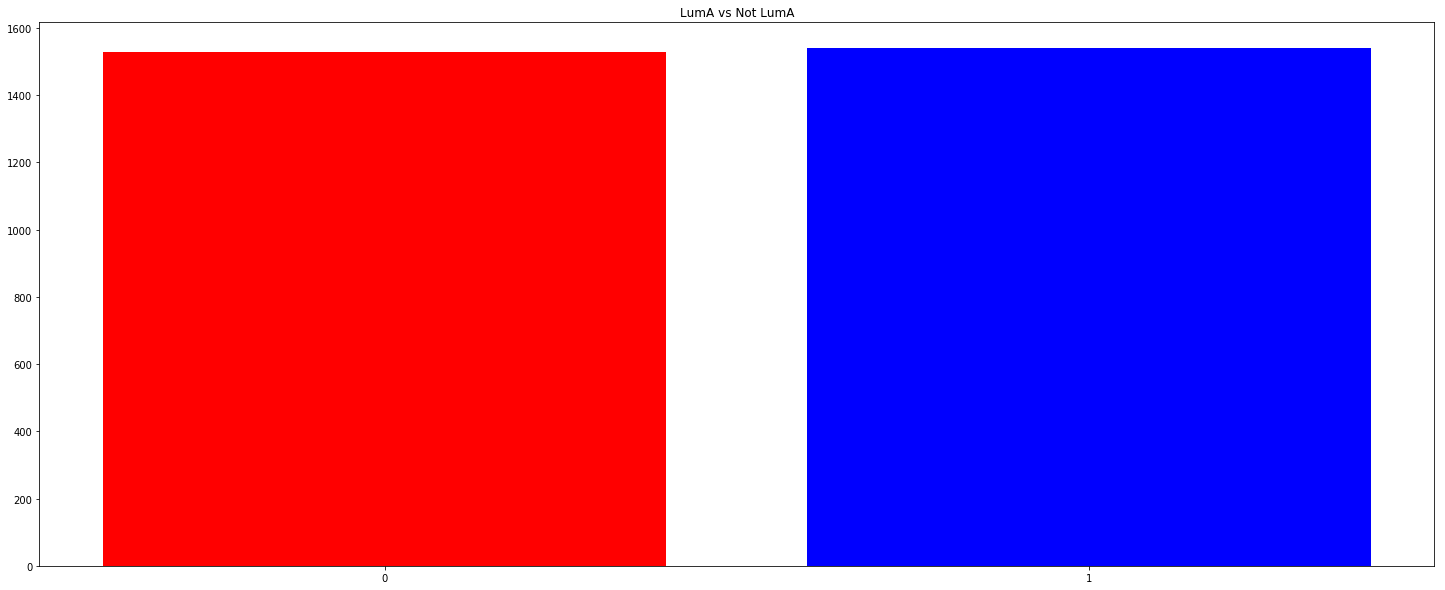

In [24]:
t = data['isLumA']
values, counts = np.unique(t, return_counts=True)
print(counts)
plt.bar(x=values,height=counts, color=["Red", "Blue"])
plt.xticks([0,1])
plt.title("LumA vs Not LumA")
plt.show()

#### Removing all columns with zero variance (i.e any constant value column)

In [25]:
# Removing zero variance cols
data = data.loc[:, (data != data.iloc[0]).any()] 
data 

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,1
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,1
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,2.430733,1.018666,-3.321928,6.882498,-1.911554,...,3.239924,0.516923,2.425054,3.074247,-1.070585,2.391182,6.167490,2.196925,3.182132,1
F2958repl,-3.321928,4.627216,-3.321928,-3.321928,-1.114219,2.097562,0.542301,-2.928133,6.972296,-1.581553,...,4.389831,0.127864,1.790839,2.953123,0.586012,2.082903,5.940774,2.351836,3.510877,0
F3057repl,-3.321928,6.965451,-3.321928,-3.321928,1.651384,1.418644,0.064947,-3.043577,8.223603,-1.267660,...,2.047489,0.952073,2.346690,3.476365,1.122679,3.046818,6.511327,3.383714,4.262995,1
F3085repl,-3.321928,4.531984,-3.321928,-3.321928,-0.594062,3.437225,0.149748,-3.160701,4.870941,-0.483202,...,4.393794,1.501286,2.705467,3.148965,-0.320549,2.185147,4.671022,1.636199,2.771947,0


#### Removing all columns with very low coefficient variance

In [16]:
data.std()

Unnamed: 0
5_8S_rRNA    0.685056
5S_rRNA      3.673739
7M1-2        0.182910
7SK          1.249174
A1BG         0.734646
               ...   
ZYG11B       0.351379
ZYX          0.529573
ZZEF1        0.489582
ZZZ3         0.485831
isLumA       0.500078
Length: 27596, dtype: float64

In [11]:
data = data.loc[:, data.std() > .1]
data

Unnamed: 0,5_8S_rRNA,5S_rRNA,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,4.511589,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,-2.523544,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,1
F3,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,-1.605984,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,-1.731622,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,1
F5,-3.321928,4.190104,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,-1.758112,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,-3.321928,-3.321928,-3.321928,-3.321928,2.430733,1.018666,-3.321928,6.882498,-1.911554,-1.940507,...,3.239924,0.516923,2.425054,3.074247,-1.070585,2.391182,6.167490,2.196925,3.182132,1
F2958repl,-3.321928,4.627216,-3.321928,-1.114219,2.097562,0.542301,-2.928133,6.972296,-1.581553,-1.819366,...,4.389831,0.127864,1.790839,2.953123,0.586012,2.082903,5.940774,2.351836,3.510877,0
F3057repl,-3.321928,6.965451,-3.321928,1.651384,1.418644,0.064947,-3.043577,8.223603,-1.267660,-2.212592,...,2.047489,0.952073,2.346690,3.476365,1.122679,3.046818,6.511327,3.383714,4.262995,1
F3085repl,-3.321928,4.531984,-3.321928,-0.594062,3.437225,0.149748,-3.160701,4.870941,-0.483202,-2.565669,...,4.393794,1.501286,2.705467,3.148965,-0.320549,2.185147,4.671022,1.636199,2.771947,0


#### As we can see we have reduced the amount of columns from 30866 to 27596. We will now preform wrs and select 1000 genes (columns)

In [13]:
X = data.drop('isLumA', axis=1)
y = data['isLumA']
# Seperate the data into two class, luminal-A and not-Luminal-A
lumA, not_lumA = X[y == 1], X[y != 1] # cahnge X and y and rename B
lumA.shape, not_lumA.shape

((1540, 27595), (1529, 27595))

#### Now we will build a list in sorted order of the Mann–Whitney U test. This is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X

In [14]:
wrs_dict = {}
for col in X.columns.values:
    current_wrs = wrs(lumA[col], not_lumA[col], alternative='two-sided') 
    wrs_dict[col] = current_wrs[1] # add p-value 
sorted_wrs_res = sorted(wrs_dict.items(), key=operator.itemgetter(1))

In [15]:
sorted_wrs_res[:10]

[('MYBL2', 5.1862491588629955e-282),
 ('PTTG1', 2.2944545421690907e-278),
 ('AF086186', 2.7138333702685002e-275),
 ('UBE2C', 4.2917326152643816e-274),
 ('CENPA', 5.751523661871411e-274),
 ('CDC45', 2.8021826710099352e-272),
 ('CDCA5', 9.634938707900045e-272),
 ('CEP55', 1.072295403185884e-271),
 ('FOXM1', 1.1637567709810184e-271),
 ('BIRC5', 2.3316560397898733e-270)]

In [26]:
corr_threshold = 0.5
count_threshold = 1000

In [39]:
final_set = [sorted_wrs_res[0][0]]
c = 1
print(c,":",final_set[0])
t = tqdm(sorted_wrs_res[1:])
for gene, _ in t:
    rhos = [spearman(X[gene], X[selected_gene])[0] for selected_gene in final_set]
    max_rho = max(rhos)
    if max_rho < corr_threshold:
        final_set.append(gene)
        c += 1
        #print(c,":",gene)
        t.set_postfix({"Gene Found":gene, "Current C": c})
    if c == count_threshold:
        break
    

1 : MYBL2







  0%|                                                                                        | 0/27594 [00:00<?, ?it/s]




  0%|                                                                              | 20/27594 [00:00<02:23, 192.30it/s]




  0%|▏                                                                             | 47/27594 [00:00<02:12, 207.51it/s]




  0%|▏                                                                             | 81/27594 [00:00<01:58, 233.04it/s]




  0%|▏                                              | 81/27594 [00:00<01:58, 233.04it/s, Gene Found=WBP1L, Current C=2]




  0%|▏                                             | 115/27594 [00:00<01:47, 255.00it/s, Gene Found=WBP1L, Current C=2]




  0%|▏                                            | 115/27594 [00:00<01:47, 255.00it/s, Gene Found=UBXN10, Current C=3]




  1%|▏                                            | 138/27594 [00:00<02:09, 211.53it/s, Gene Found=UBXN10, Current C=3]




  1

  2%|▊                                          | 500/27594 [00:14<35:53, 12.58it/s, Gene Found=AX746823, Current C=34]




  2%|▊                                          | 502/27594 [00:14<37:01, 12.20it/s, Gene Found=AX746823, Current C=34]




  2%|▊                                          | 504/27594 [00:14<36:12, 12.47it/s, Gene Found=AX746823, Current C=34]




  2%|▊                                          | 506/27594 [00:14<36:48, 12.27it/s, Gene Found=AX746823, Current C=34]




  2%|▊                                             | 506/27594 [00:14<36:48, 12.27it/s, Gene Found=UQCRH, Current C=35]




  2%|▊                                             | 508/27594 [00:14<38:41, 11.67it/s, Gene Found=UQCRH, Current C=35]




  2%|▊                                              | 508/27594 [00:14<38:41, 11.67it/s, Gene Found=NBEA, Current C=36]




  2%|▊                                              | 510/27594 [00:14<40:09, 11.24it/s, Gene Found=NBEA, Current C=36]




  2%|▊  

  2%|█                                           | 664/27594 [00:31<1:06:38,  6.73it/s, Gene Found=DEGS2, Current C=52]




  2%|█                                           | 665/27594 [00:31<1:03:53,  7.03it/s, Gene Found=DEGS2, Current C=52]




  2%|█                                          | 665/27594 [00:32<1:03:53,  7.03it/s, Gene Found=ZNF219, Current C=53]




  2%|█                                          | 666/27594 [00:32<1:04:29,  6.96it/s, Gene Found=ZNF219, Current C=53]




  2%|█                                          | 667/27594 [00:32<1:02:59,  7.12it/s, Gene Found=ZNF219, Current C=53]




  2%|█                                          | 668/27594 [00:32<1:01:20,  7.32it/s, Gene Found=ZNF219, Current C=53]




  2%|█                                            | 668/27594 [00:32<1:01:20,  7.32it/s, Gene Found=GMNN, Current C=54]




  2%|█                                            | 669/27594 [00:32<1:00:38,  7.40it/s, Gene Found=GMNN, Current C=54]




  2%|█  

  3%|█▏                                        | 772/27594 [00:48<1:14:15,  6.02it/s, Gene Found=SLITRK3, Current C=76]




  3%|█▎                                           | 772/27594 [00:48<1:14:15,  6.02it/s, Gene Found=CHRD, Current C=77]




  3%|█▎                                           | 773/27594 [00:48<1:16:50,  5.82it/s, Gene Found=CHRD, Current C=77]




  3%|█▎                                           | 774/27594 [00:48<1:15:53,  5.89it/s, Gene Found=CHRD, Current C=77]




  3%|█▏                                         | 774/27594 [00:48<1:15:53,  5.89it/s, Gene Found=SH3D21, Current C=78]




  3%|█▏                                         | 775/27594 [00:48<1:17:48,  5.74it/s, Gene Found=SH3D21, Current C=78]




  3%|█▏                                         | 776/27594 [00:48<1:16:56,  5.81it/s, Gene Found=SH3D21, Current C=78]




  3%|█▏                                         | 777/27594 [00:49<1:16:32,  5.84it/s, Gene Found=SH3D21, Current C=78]




  3%|█▏ 

  3%|█▍                                           | 883/27594 [01:09<1:32:42,  4.80it/s, Gene Found=SIX5, Current C=97]




  3%|█▍                                           | 884/27594 [01:09<1:34:02,  4.73it/s, Gene Found=SIX5, Current C=97]




  3%|█▎                                      | 884/27594 [01:09<1:34:02,  4.73it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▎                                      | 885/27594 [01:09<1:31:23,  4.87it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▎                                      | 886/27594 [01:09<1:32:37,  4.81it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▎                                      | 887/27594 [01:09<1:35:16,  4.67it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▎                                      | 888/27594 [01:10<1:33:28,  4.76it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▎                                      | 889/27594 [01:10<1:40:36,  4.42it/s, Gene Found=RAB11FIP5, Current C=98]




  3%|█▍ 

  4%|█▌                                          | 991/27594 [01:34<1:51:21,  3.98it/s, Gene Found=THRB, Current C=121]




  4%|█▎                                  | 991/27594 [01:34<1:51:21,  3.98it/s, Gene Found=APOBEC3B-AS1, Current C=122]




  4%|█▎                                  | 992/27594 [01:34<1:52:06,  3.95it/s, Gene Found=APOBEC3B-AS1, Current C=122]




  4%|█▌                                        | 992/27594 [01:34<1:52:06,  3.95it/s, Gene Found=ZBTB18, Current C=123]




  4%|█▌                                        | 993/27594 [01:34<1:53:43,  3.90it/s, Gene Found=ZBTB18, Current C=123]




  4%|█▌                                         | 993/27594 [01:35<1:53:43,  3.90it/s, Gene Found=SNRPA, Current C=124]




  4%|█▌                                         | 994/27594 [01:35<1:54:31,  3.87it/s, Gene Found=SNRPA, Current C=124]




  4%|█▌                                         | 995/27594 [01:35<1:52:02,  3.96it/s, Gene Found=SNRPA, Current C=124]




  4%|█▌ 

  4%|█▋                                       | 1099/27594 [02:04<2:14:46,  3.28it/s, Gene Found=ZBTB16, Current C=145]




  4%|█▋                                       | 1100/27594 [02:04<2:12:05,  3.34it/s, Gene Found=ZBTB16, Current C=145]




  4%|█▌                                     | 1100/27594 [02:05<2:12:05,  3.34it/s, Gene Found=BC021234, Current C=146]




  4%|█▌                                     | 1101/27594 [02:05<2:13:48,  3.30it/s, Gene Found=BC021234, Current C=146]




  4%|█▋                                         | 1101/27594 [02:05<2:13:48,  3.30it/s, Gene Found=EGOT, Current C=147]




  4%|█▋                                         | 1102/27594 [02:05<2:11:57,  3.35it/s, Gene Found=EGOT, Current C=147]




  4%|█▋                                         | 1103/27594 [02:05<2:12:06,  3.34it/s, Gene Found=EGOT, Current C=147]




  4%|█▋                                         | 1104/27594 [02:06<2:12:14,  3.34it/s, Gene Found=EGOT, Current C=147]




  4%|█▌ 

  4%|█▊                                        | 1206/27594 [02:39<2:28:57,  2.95it/s, Gene Found=CNTN4, Current C=170]




  4%|█▊                                        | 1207/27594 [02:39<2:29:03,  2.95it/s, Gene Found=CNTN4, Current C=170]




  4%|█▊                                        | 1208/27594 [02:40<2:28:59,  2.95it/s, Gene Found=CNTN4, Current C=170]




  4%|█▊                                        | 1209/27594 [02:40<2:28:57,  2.95it/s, Gene Found=CNTN4, Current C=170]




  4%|█▋                                     | 1209/27594 [02:40<2:28:57,  2.95it/s, Gene Found=KIAA0040, Current C=171]




  4%|█▋                                     | 1210/27594 [02:40<2:29:35,  2.94it/s, Gene Found=KIAA0040, Current C=171]




  4%|█▋                                     | 1210/27594 [02:41<2:29:35,  2.94it/s, Gene Found=C18orf56, Current C=172]




  4%|█▋                                     | 1211/27594 [02:41<2:30:11,  2.93it/s, Gene Found=C18orf56, Current C=172]




  4%|█▋ 

  5%|█▉                                        | 1303/27594 [03:16<3:12:21,  2.28it/s, Gene Found=GOLM1, Current C=205]




  5%|█▉                                       | 1303/27594 [03:16<3:12:21,  2.28it/s, Gene Found=ZNF483, Current C=206]




  5%|█▉                                       | 1304/27594 [03:16<3:11:52,  2.28it/s, Gene Found=ZNF483, Current C=206]




  5%|█▉                                       | 1304/27594 [03:17<3:11:52,  2.28it/s, Gene Found=ZNF624, Current C=207]




  5%|█▉                                       | 1305/27594 [03:17<3:10:22,  2.30it/s, Gene Found=ZNF624, Current C=207]




  5%|█▉                                       | 1306/27594 [03:17<3:08:04,  2.33it/s, Gene Found=ZNF624, Current C=207]




  5%|█▊                                     | 1306/27594 [03:18<3:08:04,  2.33it/s, Gene Found=AK097957, Current C=208]




  5%|█▊                                     | 1307/27594 [03:18<3:02:53,  2.40it/s, Gene Found=AK097957, Current C=208]




  5%|█▊ 

  5%|██                                       | 1406/27594 [04:01<3:33:58,  2.04it/s, Gene Found=MAGOHB, Current C=234]




  5%|██                                       | 1407/27594 [04:01<3:29:42,  2.08it/s, Gene Found=MAGOHB, Current C=234]




  5%|██                                       | 1408/27594 [04:02<3:29:23,  2.08it/s, Gene Found=MAGOHB, Current C=234]




  5%|██                                       | 1409/27594 [04:02<3:26:27,  2.11it/s, Gene Found=MAGOHB, Current C=234]




  5%|██▏                                       | 1409/27594 [04:03<3:26:27,  2.11it/s, Gene Found=NLRP5, Current C=235]




  5%|██▏                                       | 1410/27594 [04:03<3:22:21,  2.16it/s, Gene Found=NLRP5, Current C=235]




  5%|██▏                                       | 1411/27594 [04:03<3:18:39,  2.20it/s, Gene Found=NLRP5, Current C=235]




  5%|██▏                                       | 1412/27594 [04:03<3:22:17,  2.16it/s, Gene Found=NLRP5, Current C=235]




  5%|██▏

  5%|██▍                                         | 1506/27594 [04:50<3:51:29,  1.88it/s, Gene Found=MNT, Current C=266]




  5%|██▍                                         | 1507/27594 [04:51<3:51:07,  1.88it/s, Gene Found=MNT, Current C=266]




  5%|██▍                                         | 1508/27594 [04:51<3:48:36,  1.90it/s, Gene Found=MNT, Current C=266]




  5%|██▍                                         | 1509/27594 [04:52<3:47:49,  1.91it/s, Gene Found=MNT, Current C=266]




  5%|██▍                                         | 1509/27594 [04:52<3:47:49,  1.91it/s, Gene Found=TXN, Current C=267]




  5%|██▍                                         | 1510/27594 [04:52<3:49:32,  1.89it/s, Gene Found=TXN, Current C=267]




  5%|██▎                                       | 1510/27594 [04:53<3:49:32,  1.89it/s, Gene Found=RGS22, Current C=268]




  5%|██▎                                       | 1511/27594 [04:53<3:46:30,  1.92it/s, Gene Found=RGS22, Current C=268]




  5%|██▎

  6%|██▍                                      | 1607/27594 [05:45<4:14:47,  1.70it/s, Gene Found=TRIM58, Current C=297]




  6%|██▌                                        | 1607/27594 [05:45<4:14:47,  1.70it/s, Gene Found=AMD1, Current C=298]




  6%|██▌                                        | 1608/27594 [05:45<4:20:36,  1.66it/s, Gene Found=AMD1, Current C=298]




  6%|██▌                                         | 1608/27594 [05:46<4:20:36,  1.66it/s, Gene Found=PVR, Current C=299]




  6%|██▌                                         | 1609/27594 [05:46<4:28:07,  1.62it/s, Gene Found=PVR, Current C=299]




  6%|██▎                                     | 1609/27594 [05:47<4:28:07,  1.62it/s, Gene Found=NBPF25P, Current C=300]




  6%|██▎                                     | 1610/27594 [05:47<4:21:27,  1.66it/s, Gene Found=NBPF25P, Current C=300]




  6%|██▎                                     | 1611/27594 [05:47<4:17:22,  1.68it/s, Gene Found=NBPF25P, Current C=300]




  6%|██▎

  6%|██▌                                      | 1703/27594 [06:44<4:39:56,  1.54it/s, Gene Found=GTPBP2, Current C=333]




  6%|██▌                                      | 1704/27594 [06:45<4:43:33,  1.52it/s, Gene Found=GTPBP2, Current C=333]




  6%|██▌                                      | 1705/27594 [06:45<4:49:30,  1.49it/s, Gene Found=GTPBP2, Current C=333]




  6%|██▌                                      | 1706/27594 [06:46<4:51:29,  1.48it/s, Gene Found=GTPBP2, Current C=333]




  6%|██▌                                      | 1707/27594 [06:47<4:43:51,  1.52it/s, Gene Found=GTPBP2, Current C=333]




  6%|██▋                                        | 1707/27594 [06:47<4:43:51,  1.52it/s, Gene Found=INSR, Current C=334]




  6%|██▋                                        | 1708/27594 [06:47<4:43:03,  1.52it/s, Gene Found=INSR, Current C=334]




  6%|██▋                                        | 1709/27594 [06:48<4:41:56,  1.53it/s, Gene Found=INSR, Current C=334]




  6%|██▋

  7%|██▌                                    | 1807/27594 [07:52<4:53:24,  1.46it/s, Gene Found=C15orf59, Current C=361]




  7%|██▌                                    | 1808/27594 [07:53<4:55:56,  1.45it/s, Gene Found=C15orf59, Current C=361]




  7%|██▊                                        | 1808/27594 [07:53<4:55:56,  1.45it/s, Gene Found=LYAR, Current C=362]




  7%|██▊                                        | 1809/27594 [07:53<4:57:59,  1.44it/s, Gene Found=LYAR, Current C=362]




  7%|██▊                                        | 1810/27594 [07:54<4:56:18,  1.45it/s, Gene Found=LYAR, Current C=362]




  7%|██▋                                      | 1810/27594 [07:55<4:56:18,  1.45it/s, Gene Found=KRT222, Current C=363]




  7%|██▋                                      | 1811/27594 [07:55<4:59:05,  1.44it/s, Gene Found=KRT222, Current C=363]




  7%|██▋                                      | 1812/27594 [07:55<4:54:48,  1.46it/s, Gene Found=KRT222, Current C=363]




  7%|██▋

  7%|██▊                                      | 1902/27594 [09:02<5:32:20,  1.29it/s, Gene Found=SLC6A4, Current C=398]




  7%|██▊                                      | 1903/27594 [09:02<5:30:37,  1.30it/s, Gene Found=SLC6A4, Current C=398]




  7%|██▊                                      | 1903/27594 [09:03<5:30:37,  1.30it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊                                      | 1904/27594 [09:03<5:29:27,  1.30it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊                                      | 1905/27594 [09:04<5:32:47,  1.29it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊                                      | 1906/27594 [09:05<5:31:56,  1.29it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊                                      | 1907/27594 [09:05<5:25:51,  1.31it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊                                      | 1908/27594 [09:06<5:24:50,  1.32it/s, Gene Found=SEMA3C, Current C=399]




  7%|██▊

  7%|██▉                                      | 2011/27594 [10:25<5:43:39,  1.24it/s, Gene Found=KIF13A, Current C=421]




  7%|██▉                                      | 2012/27594 [10:25<5:45:08,  1.24it/s, Gene Found=KIF13A, Current C=421]




  7%|███▏                                       | 2012/27594 [10:26<5:45:08,  1.24it/s, Gene Found=MUM1, Current C=422]




  7%|███▏                                       | 2013/27594 [10:26<5:43:58,  1.24it/s, Gene Found=MUM1, Current C=422]




  7%|███▏                                       | 2014/27594 [10:27<5:47:01,  1.23it/s, Gene Found=MUM1, Current C=422]




  7%|██▉                                      | 2014/27594 [10:27<5:47:01,  1.23it/s, Gene Found=IGSF22, Current C=423]




  7%|██▉                                      | 2015/27594 [10:27<5:49:25,  1.22it/s, Gene Found=IGSF22, Current C=423]




  7%|██▉                                      | 2016/27594 [10:28<5:45:51,  1.23it/s, Gene Found=IGSF22, Current C=423]




  7%|██▉

  8%|███▏                                      | 2109/27594 [11:45<6:09:57,  1.15it/s, Gene Found=ASCL4, Current C=455]




  8%|███▏                                      | 2110/27594 [11:46<6:21:01,  1.11it/s, Gene Found=ASCL4, Current C=455]




  8%|███▏                                      | 2111/27594 [11:47<6:14:58,  1.13it/s, Gene Found=ASCL4, Current C=455]




  8%|██▉                                    | 2111/27594 [11:48<6:14:58,  1.13it/s, Gene Found=GMDS-AS1, Current C=456]




  8%|██▉                                    | 2112/27594 [11:48<6:16:15,  1.13it/s, Gene Found=GMDS-AS1, Current C=456]




  8%|███▏                                      | 2112/27594 [11:49<6:16:15,  1.13it/s, Gene Found=RBPMS, Current C=457]




  8%|███▏                                      | 2113/27594 [11:49<6:10:31,  1.15it/s, Gene Found=RBPMS, Current C=457]




  8%|███▏                                      | 2114/27594 [11:49<6:14:40,  1.13it/s, Gene Found=RBPMS, Current C=457]




  8%|███

  8%|███▎                                     | 2212/27594 [13:22<5:17:33,  1.33it/s, Gene Found=KLHDC2, Current C=484]




  8%|███▎                                     | 2213/27594 [13:22<5:22:00,  1.31it/s, Gene Found=KLHDC2, Current C=484]




  8%|███▎                                     | 2214/27594 [13:23<5:34:13,  1.27it/s, Gene Found=KLHDC2, Current C=484]




  8%|███▎                                      | 2214/27594 [13:24<5:34:13,  1.27it/s, Gene Found=BEND5, Current C=485]




  8%|███▎                                      | 2215/27594 [13:24<5:56:46,  1.19it/s, Gene Found=BEND5, Current C=485]




  8%|███▎                                      | 2216/27594 [13:25<6:12:47,  1.13it/s, Gene Found=BEND5, Current C=485]




  8%|███▎                                      | 2217/27594 [13:26<6:17:37,  1.12it/s, Gene Found=BEND5, Current C=485]




  8%|███▎                                     | 2217/27594 [13:27<6:17:37,  1.12it/s, Gene Found=BCKDHB, Current C=486]




  8%|███

  8%|███▍                                     | 2305/27594 [14:53<7:01:09,  1.00it/s, Gene Found=DUSP16, Current C=523]




  8%|███▍                                     | 2306/27594 [14:53<6:58:15,  1.01it/s, Gene Found=DUSP16, Current C=523]




  8%|███▌                                       | 2306/27594 [14:54<6:58:15,  1.01it/s, Gene Found=POLN, Current C=524]




  8%|███▌                                       | 2307/27594 [14:54<6:56:09,  1.01it/s, Gene Found=POLN, Current C=524]




  8%|███▌                                       | 2308/27594 [14:55<7:00:15,  1.00it/s, Gene Found=POLN, Current C=524]




  8%|███▌                                       | 2309/27594 [14:56<7:00:34,  1.00it/s, Gene Found=POLN, Current C=524]




  8%|███▌                                       | 2310/27594 [14:57<6:59:53,  1.00it/s, Gene Found=POLN, Current C=524]




  8%|███▌                                       | 2311/27594 [14:58<6:55:50,  1.01it/s, Gene Found=POLN, Current C=524]




  8%|███

  9%|███▎                                  | 2403/27594 [16:31<7:37:33,  1.09s/it, Gene Found=DPY19L2P4, Current C=557]




  9%|███▎                                  | 2404/27594 [16:32<7:31:00,  1.07s/it, Gene Found=DPY19L2P4, Current C=557]




  9%|███▋                                      | 2404/27594 [16:33<7:31:00,  1.07s/it, Gene Found=NCAM2, Current C=558]




  9%|███▋                                      | 2405/27594 [16:33<7:27:14,  1.07s/it, Gene Found=NCAM2, Current C=558]




  9%|███▋                                      | 2406/27594 [16:34<7:29:02,  1.07s/it, Gene Found=NCAM2, Current C=558]




  9%|███▋                                      | 2407/27594 [16:36<7:34:17,  1.08s/it, Gene Found=NCAM2, Current C=558]




  9%|███▋                                      | 2408/27594 [16:37<7:31:58,  1.08s/it, Gene Found=NCAM2, Current C=558]




  9%|███▌                                     | 2408/27594 [16:38<7:31:58,  1.08s/it, Gene Found=ZNF580, Current C=559]




  9%|███

  9%|███▊                                      | 2498/27594 [18:15<8:42:12,  1.25s/it, Gene Found=ZBTB3, Current C=594]




  9%|███▊                                      | 2499/27594 [18:16<8:39:33,  1.24s/it, Gene Found=ZBTB3, Current C=594]




  9%|███▊                                      | 2500/27594 [18:17<8:25:34,  1.21s/it, Gene Found=ZBTB3, Current C=594]




  9%|███▉                                       | 2500/27594 [18:18<8:25:34,  1.21s/it, Gene Found=AMPH, Current C=595]




  9%|███▉                                       | 2501/27594 [18:18<8:15:16,  1.18s/it, Gene Found=AMPH, Current C=595]




  9%|███▉                                       | 2502/27594 [18:19<8:06:29,  1.16s/it, Gene Found=AMPH, Current C=595]




  9%|███▋                                    | 2502/27594 [18:20<8:06:29,  1.16s/it, Gene Found=CCDC149, Current C=596]




  9%|███▋                                    | 2503/27594 [18:20<7:58:42,  1.14s/it, Gene Found=CCDC149, Current C=596]




  9%|███

KeyboardInterrupt: 

In [46]:
prev_final_set = final_set
print(prev_final_set[:10], "\nLength of final set: ",len(prev_final_set))

['MYBL2', 'WBP1L', 'UBXN10', 'LAMP5', 'C4A', 'RAB6C-AS1', 'C10orf107', 'CRIM1', 'ALAD', 'PIR'] 
Length of final set:  1000


#### We can see that the data is almost split in half.

## Part 2: Building the Model

In [7]:
X = data.drop('isLumA', axis=1).values
y = data['isLumA'].values
X.shape, y.shape

((3069, 30865), (3069,))

Split the data into 80% train and 20% train:

In [8]:
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train], X[idx_val]
y_train, y_val = y[idx_train], y[idx_val]
print("X_train shape:",X_train.shape ,"y_train shape:",y_train.shape)
print("X_val shape:",X_val.shape ,"y_val shape:",y_val.shape)

X_train shape: (2455, 30865) y_train shape: (2455,)
X_val shape: (614, 30865) y_val shape: (614,)


Fitting the Model:

Regularization happens as default in order to overcome this, we set C as large as you possible. Also, make sure to use l2 since l1 with that implementation can be painfully slow.

In [9]:
#lr = LogisticRegression(penalty='none',solver='newton-cg',random_state=0).fit(X_train, y_train)
lr = LogisticRegression(C=sys.maxsize,random_state=0).fit(X_train, y_train)

Checking the accuracy of the model, using the validation sets

In [10]:
y_pred = lr.predict(X_val)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_val, y_val)))

Accuracy of logistic regression classifier on test set: 0.89


We plot the confusion matrix along with its classification report.

In [11]:
con_matrix = sklearn.metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(con_matrix, "\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))

Confusion Matrix:
[[264  32]
 [ 38 280]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       296
           1       0.90      0.88      0.89       318

   micro avg       0.89      0.89      0.89       614
   macro avg       0.89      0.89      0.89       614
weighted avg       0.89      0.89      0.89       614



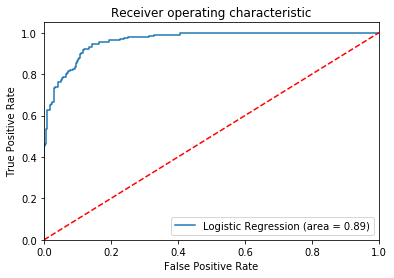

In [12]:
logit_roc_auc = roc_auc_score(y_val, lr.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Part 3: Feature Selection - Forward Selection:

Running Logistic Regression on the data using all features yields as a maximum accuracy of 0.89. We will now apply Forward selection and try and get a subset of around 100 features whom will yeild roughly the same accuracy threshold.

In [37]:
def forward_selection_single_threaded(data, X_train, y_train, X_val, y_val, max_features, C_param=1):
    # Getting all the features and remembering to remove the isLumA column
    features = [i for i in range(data.shape[1]-1)]
    selected_features = []
    selected_features_by_name = []
    highest_accu = 0
    best_feature = None
    selected_features_dict = []
    # Keeping track of time, to moniter how long it takes for each iteration
    
    for i in range(max_features):
        start = time.time()
        best_feature = None
        highest_accu = 0
        
        for feature in features:
            # decide on which features we are using (selected_features + feature)
            features_in_use = selected_features + [feature]
            #print(features_in_use, int(feature))
            X_train_filt = X_train[:,features_in_use]
            X_val_filt = X_val[:,features_in_use]
     
            # Fit a Logistic regression model
            lr = LogisticRegression(C=C_param,random_state=0).fit(X_train_filt, y_train)
            # Get the accuracy rate using the validation set
            accu_train = lr.score(X_train_filt, y_train)
            # Storing the best feature according to the highest accuracy rate.
            if accu_train > highest_accu:
                highest_accu = accu_train
                best_feature = feature
       
        # Add the best feature to the list
        selected_features.append(best_feature)
        selected_features_by_name.append(data.columns[best_feature])
        # Train the model again with these features
        X_train_filt = X_train[:,selected_features]
        X_val_filt = X_val[:,selected_features]
        lr = LogisticRegression(C=C_param,random_state=0).fit(X_train_filt, y_train)
        # Measure Validation accuracy with the features
        accu_val = lr.score(X_val_filt, y_val)
        # Remove the feature found from the list of features
        features.remove(best_feature)
        
        # Measure time
        times = time.time()-start
        # Populate dictionary of info and add it to our list and continue
        selected_features_dict.append({"Feature": selected_features_by_name.copy(),"Iteration": i+1, 
                                       "Training accuracy": highest_accu, "Validation Accuracy": accu_val, "Time":times})
    #print(selected_features,selected_features_by_name, highest_accu)
    # return a dictionary
    return (selected_features_dict, highest_accu);

Ranking each row and dividing each row into 5 (Bins)

In [23]:
def bin_rank(data, bins=5):
    data = pd.DataFrame(data)
    rank_data = data.rank(axis=1)
    for i, row in rank_data.iterrows():
        rank_data.loc[i, :] = pd.cut(row, bins=bins, labels=False)
    return rank_data.values

Splitting the data into training and testing and running forward selection to get a list of features

In [37]:
#%%time
# Organize the data into np arrays
X = data.drop('isLumA', axis=1)
# Ranking and binning data
X = bin_rank(X.values)
y = data['isLumA'].values
# Split into training and validation sets
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train], X[idx_val]
y_train, y_val = y[idx_train], y[idx_val]
X_train.shape,y_train.shape, X_val.shape, y_val.shape

((2455, 30865), (2455,), (614, 30865), (614,))

In [ ]:
# Run forward selection
max_features = 25
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, cpu_count)
#features_found_single,accu_acheived_single = forward_selection_single_threaded(data,X_train, y_train, X_val, y_val, max_features)

Present the information returned by the forward selection:

In [19]:
for f in features_found:
    print(f)

{'Feature': ['CEP55'], 'Iteration': 1, 'Training accuracy': 0.8077393075356415, 'Validation Accuracy': 0.8061889250814332, 'Time': 126.73350858688354}
{'Feature': ['CEP55', 'MAPT'], 'Iteration': 2, 'Training accuracy': 0.8334012219959267, 'Validation Accuracy': 0.8338762214983714, 'Time': 118.4947235584259}
{'Feature': ['CEP55', 'MAPT', 'NGFR'], 'Iteration': 3, 'Training accuracy': 0.8541751527494909, 'Validation Accuracy': 0.8420195439739414, 'Time': 116.31147289276123}
{'Feature': ['CEP55', 'MAPT', 'NGFR', 'AF086186'], 'Iteration': 4, 'Training accuracy': 0.8635437881873728, 'Validation Accuracy': 0.8485342019543974, 'Time': 105.13780474662781}
{'Feature': ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4'], 'Iteration': 5, 'Training accuracy': 0.8733197556008147, 'Validation Accuracy': 0.8648208469055375, 'Time': 105.13197994232178}
{'Feature': ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2'], 'Iteration': 6, 'Training accuracy': 0.8790224032586558, 'Validation Accuracy': 0.87296416

In [20]:
for itr in features_found:
    print("Iteration "+str(itr["Iteration"])+": "+str(itr["Feature"]))

Iteration 1: ['CEP55']
Iteration 2: ['CEP55', 'MAPT']
Iteration 3: ['CEP55', 'MAPT', 'NGFR']
Iteration 4: ['CEP55', 'MAPT', 'NGFR', 'AF086186']
Iteration 5: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4']
Iteration 6: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2']
Iteration 7: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B']
Iteration 8: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1']
Iteration 9: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1', 'CGA']
Iteration 10: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1', 'CGA', 'AB231703']
Iteration 11: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1', 'CGA', 'AB231703', 'DL492217']
Iteration 12: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1', 'CGA', 'AB231703', 'DL492217', 'DJ439576']
Iteration 13: ['CEP55', 'MAPT', 'NGFR', 'AF086186', 'TMC4', 'NTNG2', 'ACVR2B', 'ANTXRLP1', 'CGA', 

In [21]:
iterations = [i+1 for i in range(max_features)]
accu_train = [itr["Training accuracy"] for itr in features_found]
accu_val = [itr["Validation Accuracy"] for itr in features_found]
time = [itr["Time"] for itr in features_found]
#time_single = [itr["Time"] for itr in features_found_single]


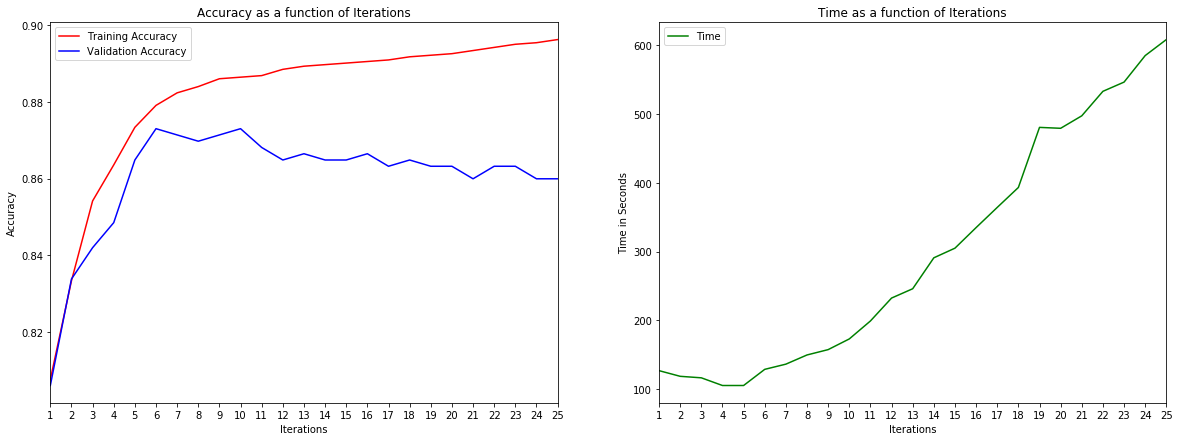

In [22]:
fig, axes = plt.subplots(1, 2,figsize=(20, 7), sharey=False)

ax = axes[0]
# Plot both accuracies 
ax.plot(iterations, accu_train, label="Training Accuracy", color="Red")
ax.plot(iterations, accu_val, label="Validation Accuracy", color="Blue")
# Ensure we have the correct scale for the iterations axis
ax.set_xlim([1, max_features])
ax.set_xticks(np.arange(1, max_features+1, 1), minor=False)

ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of Iterations')
ax.legend()

ax = axes[1]
# Plot the time
ax.plot(iterations, time, label="Time", color="Green")
#ax.plot(iterations, time_single, label="Time-Single", color="Black")
# Ensure we have the correct scale for the iterations axis
ax.set_xlim([1, max_features])
ax.set_xticks(np.arange(1, max_features+1, 1), minor=False)

ax.set_xlabel('Iterations')
ax.set_ylabel('Time in Seconds')
ax.set_title('Time as a function of Iterations')
ax.legend()

plt.show()

## Part 4: Feature Selection - mlxtend SFS:

In [9]:
# Organize the data into np arrays
X = data.drop('isLumA', axis=1)
# Ranking and binning data
X = bin_rank(X.values)
y = data['isLumA'].values
# Split into training and validation sets
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train], X[idx_val]
y_train, y_val = y[idx_train], y[idx_val]
X_train.shape,y_train.shape, X_val.shape, y_val.shape

((2455, 30865), (2455,), (614, 30865), (614,))

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

lr = LogisticRegression(C=1,random_state=0)
sfs1 = SFS(lr, 
           k_features=1, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           n_jobs=4,
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 3028 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 9524 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 18580 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 30260 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 30865 out of 30865 | elapsed:   53.9s finished

[2020-11-19 09:37:40] Features: 1/1 -- score: 0.8077393075356415

In [11]:
sfs1.subsets_

{1: {'feature_idx': (6035,),
  'cv_scores': array([0.80773931]),
  'avg_score': 0.8077393075356415,
  'feature_names': ('6035',)}}

## Part 5: Using Feature Importance for start of feature selection:

### Using Ranked Data:

In [7]:
def splitData(data, isRanked):
    if isRanked:
        X = data.drop('isLumA', axis=1)
        # Ranking and binning data
        X = bin_rank(X.values)
    else:
        X = data.drop('isLumA', axis=1).values
    y = data['isLumA'].values
    # Split into training and validation sets
    np.random.seed(42)
    indices = np.random.permutation(X.shape[0])
    idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
    X_train, X_val = X[idx_train], X[idx_val]
    y_train, y_val = y[idx_train], y[idx_val]
    return X_train, X_val, y_train, y_val

#### Decision Trees:


In [8]:
from sklearn import tree
X_train, X_val, y_train, y_val = splitData(data, True)
dt = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [9]:
y_pred = dt.predict(X_val)
print('Accuracy of Decision tree classifier on test set: {:.2f}'.format(dt.score(X_val, y_val)))

Accuracy of Decision tree classifier on test set: 0.86


In [10]:
# Get an array of importance for every feature
dt_feature_importance = dt.feature_importances_
# Get the indicies of the top 20 most important features
dt_idx_feature_importance = np.argpartition(dt_feature_importance, -20)[-20:]
# Get the actual features
dt_rank_top_features = [data.columns[i] for i in dt_idx_feature_importance]
print(dt_rank_top_features)

['TBRG4', 'FMO2', 'BAMBI', 'ANKRD30A', 'ESR1', 'AF086186', 'CDCA5', 'DTNB', 'OR7E91P', 'MAK', 'CENPA', 'PREX1', 'RAB6C-AS1', 'KLK10', 'CCNA2', 'COL17A1', 'KRT14', 'GU228584', 'CEP55', 'MAPT']


Now, we will use this array as our base array and run the feature selection algorithm

In [ ]:
X_train, X_val, y_train, y_val = splitData(data, False)
max_features = 1
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, 
                                                 cpu_count, dt_idx_feature_importance, dt_rank_top_features)

In [ ]:
for f in features_found:
    print(f)

#### Random Forest:


In [11]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_val, y_train, y_val = splitData(data, True)
rf = RandomForestClassifier().fit(X_train, y_train)

In [26]:
y_pred = rf.predict(X_val)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_val, y_val)))

Accuracy of Random Forest classifier on test set: 0.88


In [29]:
# Get an array of importance for every feature
rf_feature_importance = rf.feature_importances_
# Get the indicies of the top 20 most important features
rf_idx_feature_importance = np.argpartition(rf_feature_importance, -20)[-20:]
# Get the actual features
rf_rank_top_features = [data.columns[i] for i in rf_idx_feature_importance]
print(rf_rank_top_features)

['RHOJ', 'MCM6', 'SPC24', 'RAB6C', 'CMC2', 'NCAPD2', 'CENPF', 'MGC4836', 'PTTG1', 'KIF2C', 'HEXIM1', 'UBXN10', 'SLC24A2', 'C4A', 'CX3CR1', 'CDCA8', 'KIF14', 'KIF11', 'FIGNL1', 'XRCC2']


Now, we will use this array as our base array and run the feature selection algorithm

In [ ]:
X_train, X_val, y_train, y_val = splitData(data, False)
max_features = 1
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, 
                                                 cpu_count, rf_idx_feature_importance, rf_rank_top_features)

In [ ]:
for f in features_found:
    print(f)

#### Logistic Regression:

In [30]:
X_train, X_val, y_train, y_val = splitData(data, True)
lr = LogisticRegression().fit(X_train, y_train)

In [31]:
y_pred = lr.predict(X_val)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(lr.score(X_val, y_val)))

Accuracy of Random Forest classifier on test set: 0.90


In [33]:
# Get an array of importance for every feature
lr_feature_importance = lr.coef_[0]
# Get the indicies of the top 20 most important features
lr_idx_feature_importance = np.argpartition(lr_feature_importance, -20)[-20:]
# Get the actual features
lr_rank_top_features = [data.columns[i] for i in lr_idx_feature_importance]
print(lr_rank_top_features)

['DQ571149', 'MAPT-AS1', 'NAP1L2', 'L13714', 'MIR6752', 'MIR1204', 'SNAR-G2', 'MIR429', 'ACTG2', 'DL490813', 'KRT14', 'SNORD117', 'MIR1273D', 'KRT17', 'MIR6784', 'PGR', 'MYL7', 'MAPT', 'KRT5', 'SFRP1']


In [ ]:
#Now, we will use this array as our base array and run the feature selection algorithm

X_train, X_val, y_train, y_val = splitData(data, False)
max_features = 1
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, 
                                                 cpu_count, lr_idx_feature_importance, lr_rank_top_features)

for f in features_found:
    print(f)